### Importar Bibliotecas

In [40]:
import pandas as pd
import numpy as np
import optuna
import shap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

import joblib
import os

sns.set(style="whitegrid")
%matplotlib inline

## Carregar Dados

In [27]:
df = pd.read_csv('../data/processed/employee_attrition_processed.csv')

df.head()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,41,1,1102,1,2,1,2,0,94,3,...,False,False,False,False,False,True,False,False,True,True
1,49,0,279,8,1,2,3,1,61,2,...,False,False,False,False,True,False,False,True,False,False
2,37,1,1373,2,2,4,4,1,92,2,...,True,False,False,False,False,False,False,False,True,True
3,33,0,1392,3,4,5,4,0,56,3,...,False,False,False,False,True,False,False,True,False,True
4,27,0,591,2,1,7,1,1,40,3,...,True,False,False,False,False,False,False,True,False,False


tudo certo!

- Attrition virou 0/1

- Gender virou 0/1

- OverTime, MaritalStatus, JobRole, etc., viraram dummies (True/False)

### train_test_split

In [28]:
X = df.drop('Attrition', axis=1)
y = df['Attrition']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(f"Tamanho do treino: {X_train.shape}")
print(f"Tamanho do teste: {X_test.shape}")

Tamanho do treino: (1176, 47)
Tamanho do teste: (294, 47)


### Smote

In [ ]:
smote = SMOTE(random_state=42)
    
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
print("Distribuição original:", y_train.value_counts(normalize=True))
print("Distribuição após SMOTE:", y_train_resampled.value_counts(normalize=True))

Distribuição original: Attrition
0    0.838435
1    0.161565
Name: proportion, dtype: float64
Distribuição após SMOTE: Attrition
0    0.5
1    0.5
Name: proportion, dtype: float64


### K-fold

In [57]:
neg, pos = Counter(y_train_resampled)[0], Counter(y_train_resampled)[1]
spw = neg / pos

xgb_kfold = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=spw,
    **study.best_params
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    xgb_kfold,
    X_train_resampled, 
    y_train_resampled,
    scoring='f1',
    cv=cv
)

print(f"F1 CV média: {scores.mean():.4f} ± {scores.std():.4f}")

F1 CV média: 0.9245 ± 0.0119


modelo está performando muito bem no conjunto de treino balanceado.

### XGBoost

In [30]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [17]:
y_pred_xgb = xgb_model.predict(X_test)
print("=== XGBoost ===")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print("ROC AUC XGB:", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]))

=== XGBoost ===
[[238   9]
 [ 30  17]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       247
           1       0.65      0.36      0.47        47

    accuracy                           0.87       294
   macro avg       0.77      0.66      0.70       294
weighted avg       0.85      0.87      0.85       294

ROC AUC XGB: 0.7820656387285726


XGBoost

- Acurácia: 0.87

- ROC AUC: 0.78

- F1-Score: 0.47 para a classe 1

### Optuna

In [23]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5)
    }

    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        **params
    )

    model.fit(X_train_resampled, y_train_resampled)

    y_pred = model.predict(X_test)

    return f1_score(y_test, y_pred, pos_label=1)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=600) 


[I 2025-05-15 09:05:34,979] A new study created in memory with name: no-name-8c9abe9e-b5c2-4452-9465-fa33afc2224e
[I 2025-05-15 09:05:36,014] Trial 0 finished with value: 0.5405405405405406 and parameters: {'n_estimators': 988, 'max_depth': 11, 'learning_rate': 0.03182292254894376, 'subsample': 0.7992544826486951, 'colsample_bytree': 0.9132676737932411, 'gamma': 2.7819754308192755, 'reg_alpha': 0.7105680521342017, 'reg_lambda': 0.08325489806132735}. Best is trial 0 with value: 0.5405405405405406.
[I 2025-05-15 09:05:36,437] Trial 1 finished with value: 0.48717948717948717 and parameters: {'n_estimators': 240, 'max_depth': 14, 'learning_rate': 0.023025621885461763, 'subsample': 0.6636219727317773, 'colsample_bytree': 0.7937667321618265, 'gamma': 3.1476929578738404, 'reg_alpha': 2.3292844933770187, 'reg_lambda': 3.491277248785724}. Best is trial 0 with value: 0.5405405405405406.
[I 2025-05-15 09:05:37,113] Trial 2 finished with value: 0.4810126582278481 and parameters: {'n_estimators': 7

In [24]:
print("Melhores parâmetros:")
print(study.best_params)

print("Melhor F1-score para classe 1:")
print(study.best_value)

Melhores parâmetros:
{'n_estimators': 644, 'max_depth': 3, 'learning_rate': 0.29064731576158676, 'subsample': 0.5753162207595865, 'colsample_bytree': 0.71602666308235, 'gamma': 2.189662722372648, 'reg_alpha': 0.06712719322990318, 'reg_lambda': 1.7063197664700689}
Melhor F1-score para classe 1:
0.5977011494252874


Com esse contexto, um F1-score de 0.5714 indica que o modelo está razoavelmente equilibrado entre a precisão e o recall, mas ainda não é ótimo. Isso é um indicativo de que o modelo consegue identificar a demissão de um funcionário (classe 1) com alguma precisão, mas não de forma robusta o suficiente para ser considerado confiável em um cenário crítico.

### Melhorar F1-score

In [ ]:
best_params = study.best_params

neg, pos = Counter(y_train_resampled)[0], Counter(y_train_resampled)[1]
spw = neg / pos

xgb_final = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=spw,
    **best_params
)

xgb_final.fit(X_train_resampled, y_train_resampled)

probs = xgb_final.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.1, 0.9, 0.01)

results = []
for t in thresholds:
    preds = (probs >= t).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, preds, average='binary')
    results.append((t, precision, recall, f1))

th_df = pd.DataFrame(results, columns=['Threshold','Precision','Recall','F1'])

best = th_df.loc[th_df['F1'].idxmax()]
print("🎯 Melhor Threshold encontrado:")
print(best)


🎯 Melhor Threshold encontrado:
Threshold    0.520000
Precision    0.684211
Recall       0.553191
F1           0.611765
Name: 42, dtype: float64


In [ ]:
neg, pos = Counter(y_train_resampled)[0], Counter(y_train_resampled)[1]
spw = neg / pos

xgb_final = XGBClassifier(
    use_label_encoder=False, eval_metric='logloss', random_state=42,
    scale_pos_weight=spw,
    **study.best_params
)
xgb_final.fit(X_train_resampled, y_train_resampled)

from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(
    xgb_final,
    X_train_resampled, y_train_resampled,
    scoring='f1', cv=cv
)
print("F1 CV média:", scores.mean())

probs_final = xgb_final.predict_proba(X_test)[:, 1]
preds_final = (probs_final >= 0.52).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test, preds_final))


F1 CV média: 0.9244634816669569
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       247
           1       0.68      0.55      0.61        47

    accuracy                           0.89       294
   macro avg       0.80      0.75      0.77       294
weighted avg       0.88      0.89      0.88       294



,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,41,1,1102,1,2,1,2,0,94,3,...,False,False,False,False,False,True,False,False,True,True
1,49,0,279,8,1,2,3,1,61,2,...,False,False,False,False,True,False,False,True,False,False
2,37,1,1373,2,2,4,4,1,92,2,...,True,False,False,False,False,False,False,False,True,True
3,33,0,1392,3,4,5,4,0,56,3,...,False,False,False,False,True,False,False,True,False,True
4,27,0,591,2,1,7,1,1,40,3,...,True,False,False,False,False,False,False,True,False,False


F1 médio no treino (CV): 0.92

- F1 na classe 1 no teste: 0.61

- Precision: 0.68

- Recall: 0.55

Interpretação:

- O modelo tá aprendendo bem no treino (dados balanceados).

- Mas no teste real, ainda sofre com recall (difícil prever quem sai da empresa).

- Gap entre treino e teste sugere que o comportamento da classe 1 no teste é diferente ou escassa.

### SHAP (SHapley Additive exPlanations)

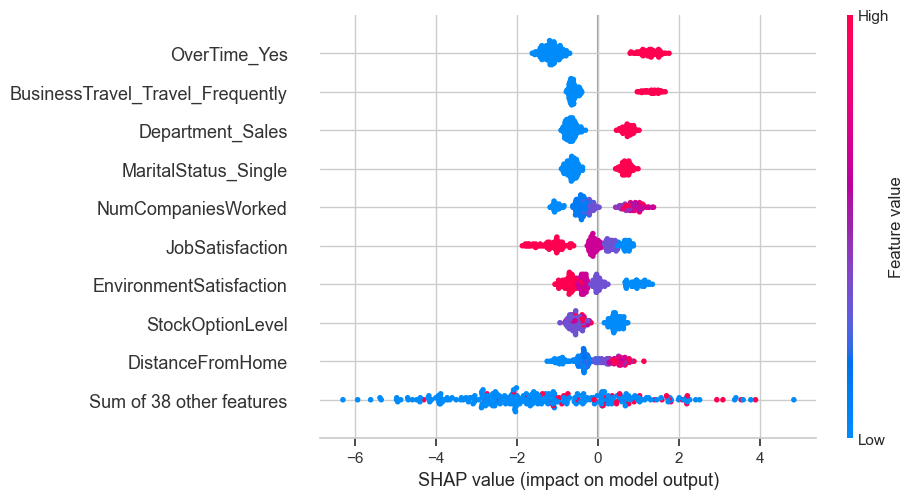

In [58]:
explainer = shap.Explainer(xgb_final)

shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values)

In [53]:
feature_names = X_train.columns.tolist()
print(len(feature_names), feature_names)

new_row = dict.fromkeys(feature_names, 0)

X_new = pd.DataFrame([{
    'Age': 32,
    'DailyRate': 800,
    'DistanceFromHome': 10,
    'Education': 3,
    'EmployeeNumber': 9999,
    'EnvironmentSatisfaction': 4,
    'Gender': 1,
    'HourlyRate': 60,
    'JobInvolvement': 3,
    'JobLevel': 2,
    'JobSatisfaction': 3,
    'MonthlyIncome': 4500,
    'MonthlyRate': 20000,
    'NumCompaniesWorked': 2,
    'PercentSalaryHike': 15,
    'PerformanceRating': 3,
    'RelationshipSatisfaction': 2,
    'StockOptionLevel': 0,
    'TotalWorkingYears': 8,
    'TrainingTimesLastYear': 2,
    'WorkLifeBalance': 3,
    'YearsAtCompany': 5,
    'YearsInCurrentRole': 2,
    'YearsSinceLastPromotion': 1,
    'YearsWithCurrManager': 3,
    'MonthlyIncome_log': np.log1p(4500),
    'TotalWorkingYears_log': np.log1p(8),
    'BusinessTravel_Travel_Frequently': 0,
    'BusinessTravel_Travel_Rarely': 1,
    'Department_Research & Development': 1,
    'Department_Sales': 0,
    'EducationField_Life Sciences': 0,
    'EducationField_Marketing': 0,
    'EducationField_Medical': 1,
    'EducationField_Other': 0,
    'EducationField_Technical Degree': 0,
    'JobRole_Human Resources': 0,
    'JobRole_Laboratory Technician': 0,
    'JobRole_Manager': 1,
    'JobRole_Manufacturing Director': 0,
    'JobRole_Research Director': 0,
    'JobRole_Research Scientist': 0,
    'JobRole_Sales Executive': 0,
    'JobRole_Sales Representative': 0,
    'MaritalStatus_Married': 1,
    'MaritalStatus_Single': 0,
    'OverTime_Yes': 0
}])

X_new = X_new[feature_names]

xgb_loaded = joblib.load('models/xgb_attrition_final.pkl')
threshold_loaded = joblib.load('models/threshold_optimizado.pkl')

probs_new = xgb_loaded.predict_proba(X_new)[:, 1]
pred_new  = (probs_new >= threshold_loaded).astype(int)

print(f"Prob. de saída: {probs_new[0]:.4f}")
print(f"Predição final: {pred_new[0]}  (1=sai, 0=fica)")


47 ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'MonthlyIncome_log', 'TotalWorkingYears_log', 'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely', 'Department_Research & Development', 'Department_Sales', 'EducationField_Life Sciences', 'EducationField_Marketing', 'EducationField_Medical', 'EducationField_Other', 'EducationField_Technical Degree', 'JobRole_Human Resources', 'JobRole_Laboratory Technician', 'JobRole_Manager', 'JobRole_Manufacturing Director', 'JobRole_Research Director', 'JobRole_Research Scientist', 'JobRole_Sales Executive', 'JobRole_S

Prob. de saída: 0.0116

(1=sai, 0=fica)
Predição final: 0 